In [23]:
import os
import numpy as np
import time
import tensorflow as tf
import keras.api._v2.keras as keras
from tensorflow.keras import datasets, layers, models 
import matplotlib.pyplot as plt

seed = 12345
np.random.seed(seed) 
tf.random.set_seed(seed) 

num_epochs = 10
learning_rate = .001

Fashion MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


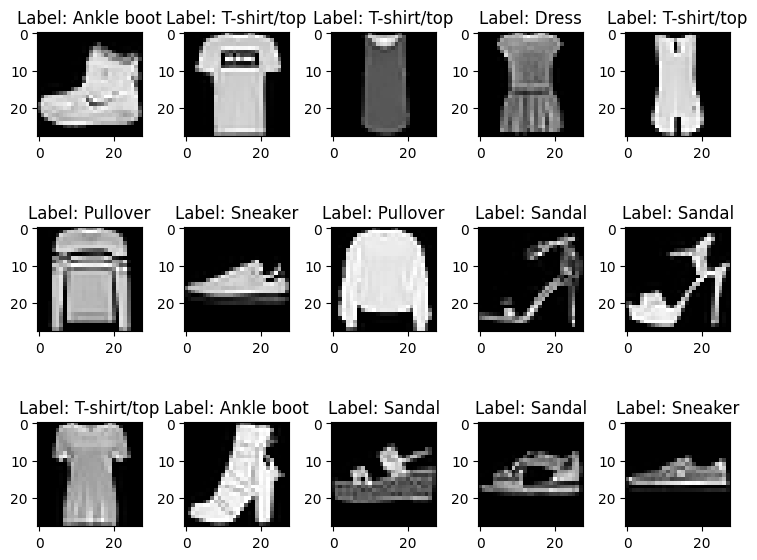

In [24]:
from tensorflow.python import data
##loading datasets 
dataset = 1 # choose dataset
if dataset ==1:
  (X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

  ##print shape
  print('Fashion MNIST Dataset Shape:')
  print('X_train: ' + str(X_train.shape))
  print('Y_train: ' + str(Y_train.shape))
  print('X_test:  '  + str(X_test.shape))
  print('Y_test:  '  + str(Y_test.shape))                                   
  # Normalize pixel values to be between 0 and 1
  train_images, test_images = X_train / 255.0, X_test / 255.0
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

  ##Verify Dataset
  # specify the number of rows and columns you want to see
  num_row = 3
  num_col = 5

  # get a segment of the dataset
  num = num_row*num_col
  images = X_train[:num]
  labels = Y_train[:num]

  # plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num_row*num_col):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i], cmap='gray')
      ax.set_title('Label: {}'.format(class_names[labels[i]]))
  plt.tight_layout()
  plt.show()

  

In [25]:
##weight initialization techniques
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
# Random Normal Distribution
from tensorflow.keras import layers
from tensorflow.keras import initializers

initializer = tf.keras.initializers.RandomNormal(
mean=0., stddev=1.)
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)


# Normailzed Xavier/Glorot Uniform Initialization
from tensorflow.keras import layers
from tensorflow.keras import initializers

initializer = tf.keras.initializers.GlorotNormal()
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)


# He Normal Initialization
from tensorflow.keras import layers
from tensorflow.keras import initializers

initializer = tf.keras.initializers.HeNormal()
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

#tf.keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None, kernel_constraint=None, bias_constraint=None,)

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

class RFASquential(tf.keras.Sequential):
    
    def __init__(self, *args, **kwargs):
        super(RFASquential, self).__init__(*args, **kwargs)

    def set_rfa(self, rfa_enabled=True, num_output_neurons=None):
        """
        Enable or disable Random Feedback Alignment for this model. If enabled, 
        the output layer of the model is replaced with an RFA layer. If disabled, 
        the original output layer is restored.
        """
        self.rfa_enabled = rfa_enabled
        
        if rfa_enabled:
            # Replace all layers with RFA layers
            self.original_layers = self.layers.copy()
            self.num_output_neurons = num_output_neurons or self.original_layers[-1].output_shape[-1]
            self.feedback_weights = tf.Variable(tf.random.normal((self.num_output_neurons, self.num_output_neurons)), trainable=False)
            self.rfa_layers = []
            for layer in self.original_layers:
                rfa_layer = RFALayer(self.feedback_weights)
                self.rfa_layers.append(rfa_layer)
                self.add(rfa_layer)
        else:
            # Restore the original layers
            for layer in self.rfa_layers:
                self.pop()
            self.original_layers[-1].trainable = True
            self.layers = self.original_layers

class RFALayer(tf.keras.layers.Layer):
    
    def __init__(self, feedback_weights, **kwargs):
        super(RFALayer, self).__init__(**kwargs)
        self.feedback_weights = feedback_weights

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.bias = self.add_weight(name='bias', 
                                    shape=(self.feedback_weights.shape[0],), 
                                    initializer='zeros')
        self.local_weights = self.add_weight(name='local_weights',
                                             shape=(input_dim, self.feedback_weights.shape[0]),
                                             initializer='random_normal')

    def call(self, inputs):
        # Compute output using Random Feedback Alignment
        local_activations = tf.matmul(inputs, self.local_weights)
        output = local_activations + self.bias
        return output




In [33]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Create the convolutional base
model = RFASquential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# Enable RFA
model.set_rfa(rfa_enabled=True, num_output_neurons=10)
model.summary()


model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mse', 'mae', recall_m, f1_m,precision_m])

history = model.fit(X_train, Y_train, epochs=10, 
                    validation_data=(X_test, Y_test))


Model: "rfa_squential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 576)           

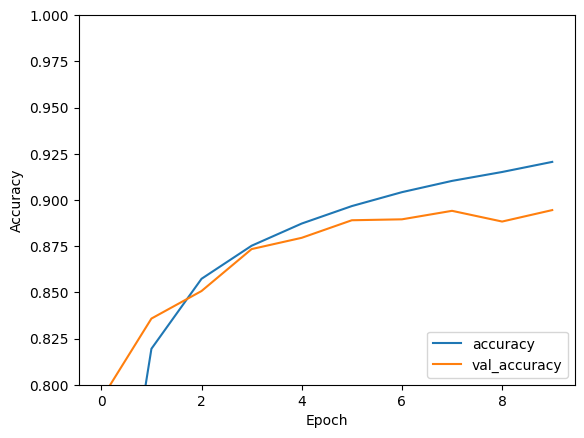

In [34]:
 #plot preds vs true values for test data 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

In [35]:
from sklearn.metrics import confusion_matrix
# Need to run this first at the beggining of experiments
cm_array = []


In [36]:
#Make sure we run this after each experiment

# Make predictions on test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred, normalize='true')

# Add confusion matrix to array
cm_array.append(cm)

313/313 [==============================] - 1s 2ms/step


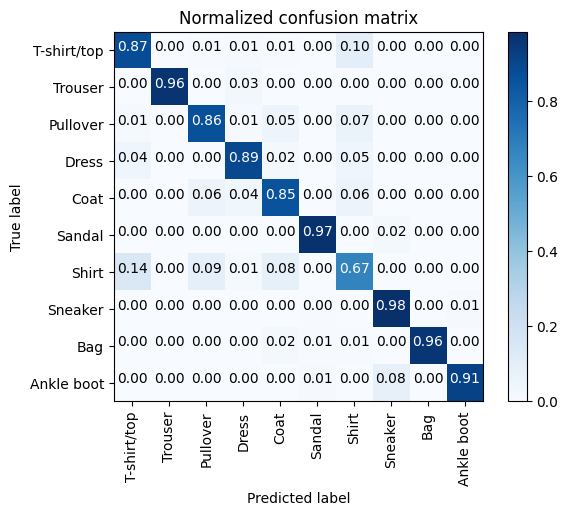

In [37]:
# Compute average confusion matrix


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

avg_cm = np.mean(cm_array, axis=0)

# Plot confusion matrix
plt.imshow(avg_cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add the numbers to the plot
for i in range(avg_cm.shape[0]):
    for j in range(avg_cm.shape[1]):
        plt.text(j, i, format(avg_cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if avg_cm[i, j] > 0.5 else "black")

plt.show()

<h1>Code for the Dataset Huge stock Market Dataset for regression<h1>


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
# LOAD APPLE DATA FOR STOCKS
# Load the data into a pandas DataFrame we will. read the specific stock that we are trying to predict
data = pd.read_csv('aapl.us.txt')

# THEN, SECOND BLOCK Convert the date column to a datetime object and set as the index
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)



# IF ABOVE CELL IS RAN, RUN THIS CELL.

# Define the time window for feature engineering
time_window = 100

# Define the target variable as the closing price
target_col = 'Close'

# Add features for moving averages of closing price
for i in [5, 10, 20, 50, 100]:
    data['MA' + str(i)] = data[target_col].rolling(i).mean()

# Add features for exponential moving averages of closing price
for i in [5, 10, 20, 50, 100]:
    data['EMA' + str(i)] = data[target_col].ewm(span=i, adjust=False).mean()

# Add features for rate of change of closing price
for i in [5, 10, 20, 50, 100]:
    data['ROC' + str(i)] = ((data[target_col] - data[target_col].shift(i)) / data[target_col].shift(i)) * 100.0

# Add features for Bollinger Bands
ma = data['Close'].rolling(window=time_window).mean()
std = data['Close'].rolling(window=time_window).std()
data['UpperBand'] = ma + 2 * std
data['LowerBand'] = ma - 2 * std


# Drop rows with NaN values
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8264 entries, 1985-01-30 to 2017-11-10
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8264 non-null   float64
 1   High       8264 non-null   float64
 2   Low        8264 non-null   float64
 3   Close      8264 non-null   float64
 4   Volume     8264 non-null   int64  
 5   OpenInt    8264 non-null   int64  
 6   MA5        8264 non-null   float64
 7   MA10       8264 non-null   float64
 8   MA20       8264 non-null   float64
 9   MA50       8264 non-null   float64
 10  MA100      8264 non-null   float64
 11  EMA5       8264 non-null   float64
 12  EMA10      8264 non-null   float64
 13  EMA20      8264 non-null   float64
 14  EMA50      8264 non-null   float64
 15  EMA100     8264 non-null   float64
 16  ROC5       8264 non-null   float64
 17  ROC10      8264 non-null   float64
 18  ROC20      8264 non-null   float64
 19  ROC50      8264 non-null   flo

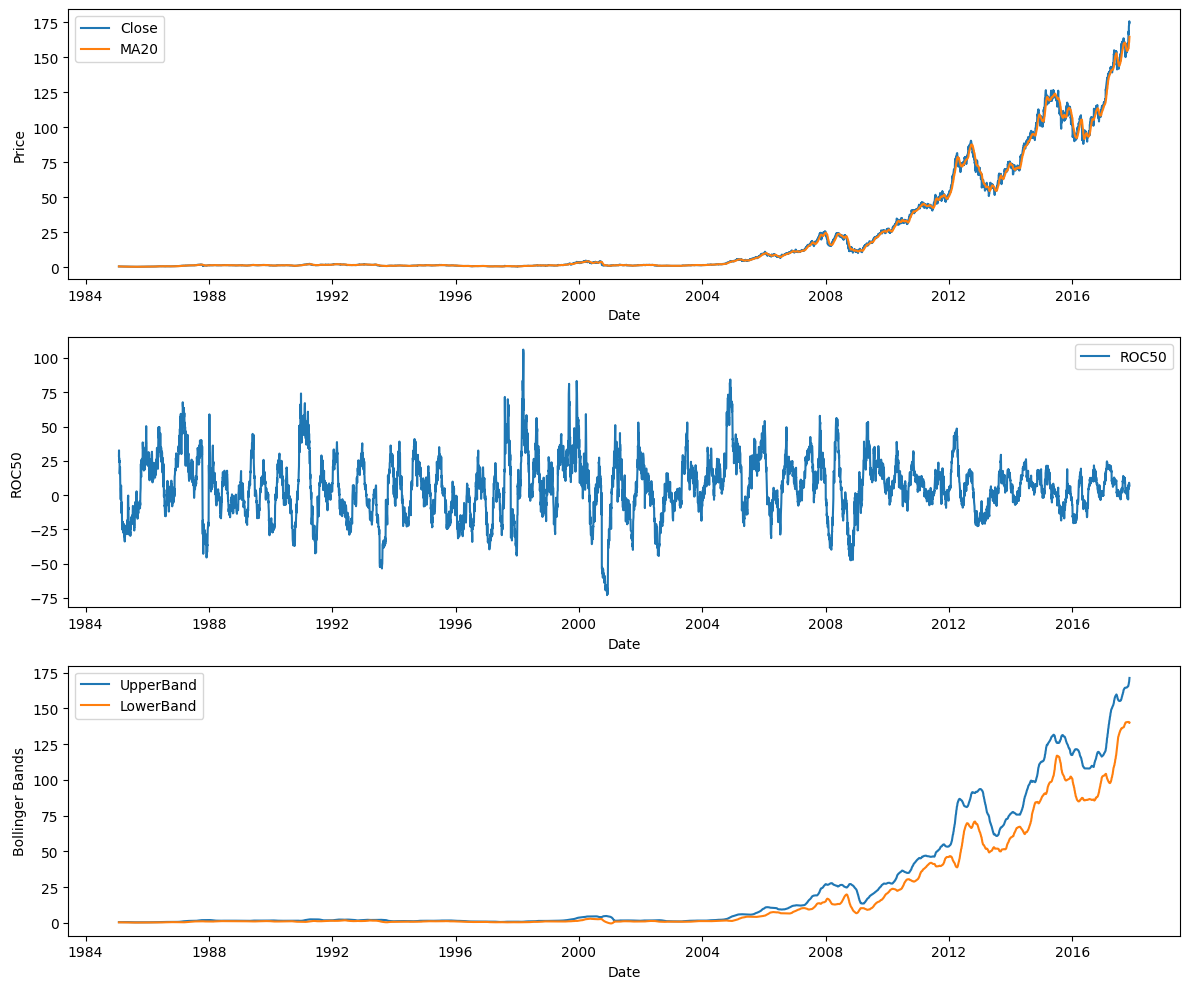

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(12,10))

axs[0].plot(data.index, data['Close'], label='Close')
axs[0].plot(data.index, data['MA20'], label='MA20')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(data.index, data['ROC50'], label='ROC50')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('ROC50')
axs[1].legend()

axs[2].plot(data.index, data['UpperBand'], label='UpperBand')
axs[2].plot(data.index, data['LowerBand'], label='LowerBand')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bollinger Bands')
axs[2].legend()

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import os
import numpy as np
import time
import tensorflow as tf
import keras.api._v2.keras as keras
from tensorflow.keras import datasets, layers, models 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
X = []
Y = []

window = 50

# adding Moving average, Exponential moving average, bollinger bands to the dataset

# creating a data with window if 50 size, like last 50 days data
for i in range(window, len(data)):
  temp = []
  for j in range(i-window, i):
    x = np.array([
        data['Close'][j],
        data['MA100'][j],
        data['MA50'][j],
        data['EMA50'][j],
        data['EMA100'][j],
        data['ROC100'][j],
        data['ROC20'][j],
        data['UpperBand'][j],
        data['LowerBand'][j]])
    
    temp.append(x)
  X.append(np.array(temp).reshape(window,9))
  Y.append(data['Close'][i])

  
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True)

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


Y_train = y_train.reshape(x_train.shape[0])
Y_val= y_test.reshape(x_val.shape[0])
Y_test = y_test.reshape(x_test.shape[0])

X_train = x_train.reshape(x_train.shape[0], window, 9, 1)
X_val = x_test.reshape(x_val.shape[0], window, 9, 1)
X_test = x_test.reshape(x_test.shape[0], window, 9, 1)

In [11]:
##weight initialization techniques

# Random Normal Distribution
from tensorflow.keras import layers
from tensorflow.keras import initializers

init_technique = 'h'

if init_technique =='r': 
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=42)
  layer_activiation = tf.keras.layers.Dense(64,  activation='relu',  kernel_initializer=initializer)
  layer_technique = tf.keras.layers.Dense(1, kernel_initializer=initializer)

# Normailzed Xavier/Glorot Uniform Initializations
elif init_technique =='x': 
  initializer = tf.keras.initializers.glorot_uniform(seed=42)
  layer_activiation  = layers.Dense(64, activation='relu',  kernel_initializer=initializer)
  layer_technique = tf.keras.layers.Dense(1, kernel_initializer=initializer)


# He Normal Initialization
elif init_technique =='h':
  initializer = tf.keras.initializers.HeNormal(seed=42)
  layer_activiation = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer)
  layer_technique = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [16]:
##Create the convolutional base
model = RFASquential()
model.add(layers.Conv2D(64, kernel_size=(3,1), activation='relu', input_shape=(50, 9, 1)))
model.add(layers.MaxPooling2D(1,1))
model.add(layers.Conv2D(64, kernel_size=(3,1),activation='relu'))
model.add(layers.MaxPooling2D(1,1))
model.add(layers.Conv2D(64, kernel_size=(3,1),activation='relu'))
model.add(layers.MaxPooling2D(1,1))

#add dense layers
model.add(layers.Flatten())
model.add(layer_activiation)
model.add(layer_technique)


model.set_rfa(rfa_enabled=True, num_output_neurons=1)
model.summary()
print(init_technique)

# Create the convolutional base
# model = RFASquential()
# model.add(layers.Conv2D(64, (3, 1), activation='relu', input_shape=(50, 9, 1)))
# model.add(layers.MaxPooling2D((2, 1)))
# model.add(layers.Conv2D(64, (3, 1), activation='relu'))
# model.add(layers.MaxPooling2D((2, 1)))
# model.add(layers.Conv2D(64, (3, 1), activation='relu'))
# # Add dense layers
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# # Enable RFA
# model.set_rfa(rfa_enabled=True, num_output_neurons=10)

# model.summary()

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# history = model.fit(X_train, Y_train, epochs=10, 
#                     validation_data=(X_test, Y_test))


Model: "rfa_squential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 9, 64)         256       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 9, 64)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 9, 64)         12352     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 9, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 9, 64)         12352     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 44, 9, 64)    

In [17]:
# model.compile(optimizer='RMSprop',
#               loss='mse',
#               metrics=['mse', 'mae'])

# history = model.fit(X_train, Y_train, epochs=10, batch_size=100, verbose=1, shuffle=True, validation_data=(X_val, Y_val))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', 'mae'])

history = model.fit(X_train, Y_train, epochs=10, 
                    validation_data=(X_test, Y_test))

Epoch 1/10
154/154 [==============================] - 7s 10ms/step - loss: 1713.0197 - mse: 1713.0197 - mae: 20.5558 - val_loss: 152.7066 - val_mse: 152.7066 - val_mae: 6.7176
Epoch 2/10
154/154 [==============================] - 2s 10ms/step - loss: 23.7832 - mse: 23.7832 - mae: 2.6182 - val_loss: 16.5264 - val_mse: 16.5264 - val_mae: 2.0797
Epoch 3/10
154/154 [==============================] - 1s 7ms/step - loss: 17.1498 - mse: 17.1498 - mae: 2.0556 - val_loss: 14.9987 - val_mse: 14.9987 - val_mae: 1.8788
Epoch 4/10
154/154 [==============================] - 1s 7ms/step - loss: 14.0413 - mse: 14.0413 - mae: 1.8335 - val_loss: 12.1208 - val_mse: 12.1208 - val_mae: 1.8249
Epoch 5/10
154/154 [==============================] - 1s 9ms/step - loss: 11.3640 - mse: 11.3640 - mae: 1.8545 - val_loss: 10.2830 - val_mse: 10.2830 - val_mae: 1.8125
Epoch 6/10
154/154 [==============================] - 3s 17ms/step - loss: 10.5837 - mse: 10.5837 - mae: 1.8047 - val_loss: 11.7301 - val_mse: 11.7301 

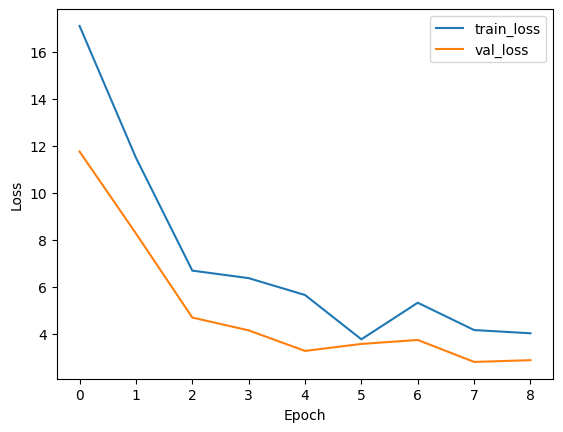

In [14]:
 #plot preds vs true values for test data  For the dataset 2
plt.plot(history.history['loss'][1:], label='train_loss')
plt.plot(history.history['val_loss'][1:], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [19]:
model.evaluate(X_test, Y_test)

52/52 [==============================] - 0s 3ms/step - loss: 5.1701 - mse: 5.1701 - mae: 1.2100


[5.170094013214111, 5.170094013214111, 1.2099984884262085]

52/52 [==============================] - 0s 2ms/step


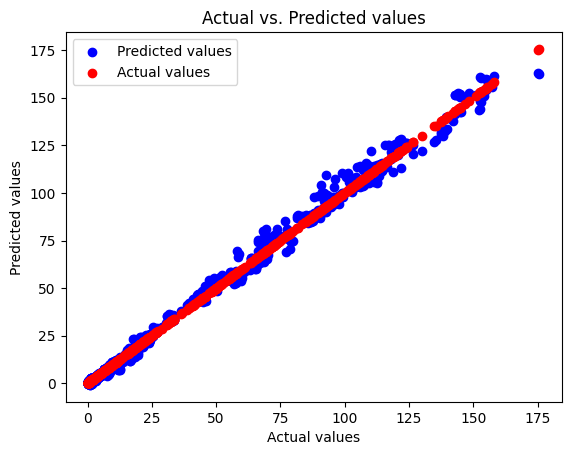

In [18]:
y_pred = model.predict(X_test)

y_pred = y_pred.reshape(Y_test.shape)
# Plot the predicted vs. actual values
plt.scatter(Y_test, y_pred, color='blue', label='Predicted values')
plt.scatter(Y_test, Y_test, color='red', label='Actual values')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted values")
plt.legend()
plt.show()

In [20]:
PRECISION_ARRAY = [0.9014,0.8880,0.9079,0.9037]
F1_ARRAY = [1.5227,1.3620,1.5359,1.5260]
RECALL_ARRAY = [4.9430,5.0176,2.9543,4.9311,5.7021]
VAL_LOSS = [0.3522,0.3826,0.3614,0.3508,0.3289]
ACCURAY_ARRAY = [0.9171,0.8454,0.9193,0.9165,0.9144]

print("Recall mean =",np.mean(VAL_LOSS))
print("Precision mean = ", np.mean(PRECISION_ARRAY))
print("F1 mean =",np.mean(F1_ARRAY))
print("Recall mean =",np.mean(RECALL_ARRAY))
print("Accuracy mean =",np.mean(ACCURAY_ARRAY))

Recall mean = 0.35518
Precision mean =  0.90025
F1 mean = 1.48665
Recall mean = 4.709619999999999
Accuracy mean = 0.9025399999999999
